# 포르투갈 은행의 마케팅 데이터 분석

# 1. 개요

## 문제 확인:
- 고객이 정기 예금을 가입할 가능성을 예측
- 가장 정확한 분류 모델을 개발하여 고객이 정기 예금을 가입할지 여부 예측
- 모델을 통해 도출한 인사이트를 바탕으로 비즈니스 전략을 제시


## 예상 분석 질문
- 특정 직업군에서 정기 예금 가입률이 높은가?
- 교육 수준에 따라 정기 예금 가입률이 달라지는가?
- 과거 마케팅 캠페인의 성공 여부가 현재 캠페인의 성공에 영향을 미치는가?
- 월별 정기 예금 가입률의 차이는 무엇인가?
- 고객의 나이와 정기 예금 가입 여부 간의 관계는 무엇인가?
- 정기 예금 가입을 예측하기 위해 사용할 수 있는 가장 중요한 변수는 무엇인가?

# 2. 준비

In [ ]:
!pip install koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 37.1 MB/s eta 0:00:00


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.0 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.tree import plot_tree
from xgboost import XGBClassifier, plot_importance
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV

In [ ]:
# 파일 불러오기
file_path = "/content/drive/MyDrive/codeit/data/bank-additional-full.csv"

# 원본 파일이 ;로 구분되어 있으므로 sep 파라미터 사용
raw_train = pd.read_csv(file_path, sep=';')

In [ ]:
raw_train

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


# 3. 데이터 분석

#### 3.1. 기본 정보 확인

In [ ]:
# 데이터 기본 정보

print(raw_train.info())
print('=' * 100)
print(raw_train.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [ ]:
# 목표 변수를 수치로 변환
raw_train['y'] = raw_train['y'].map({'yes':1, 'no':0})

### 3.2. 기본 통계

#### 수치형 상관관계

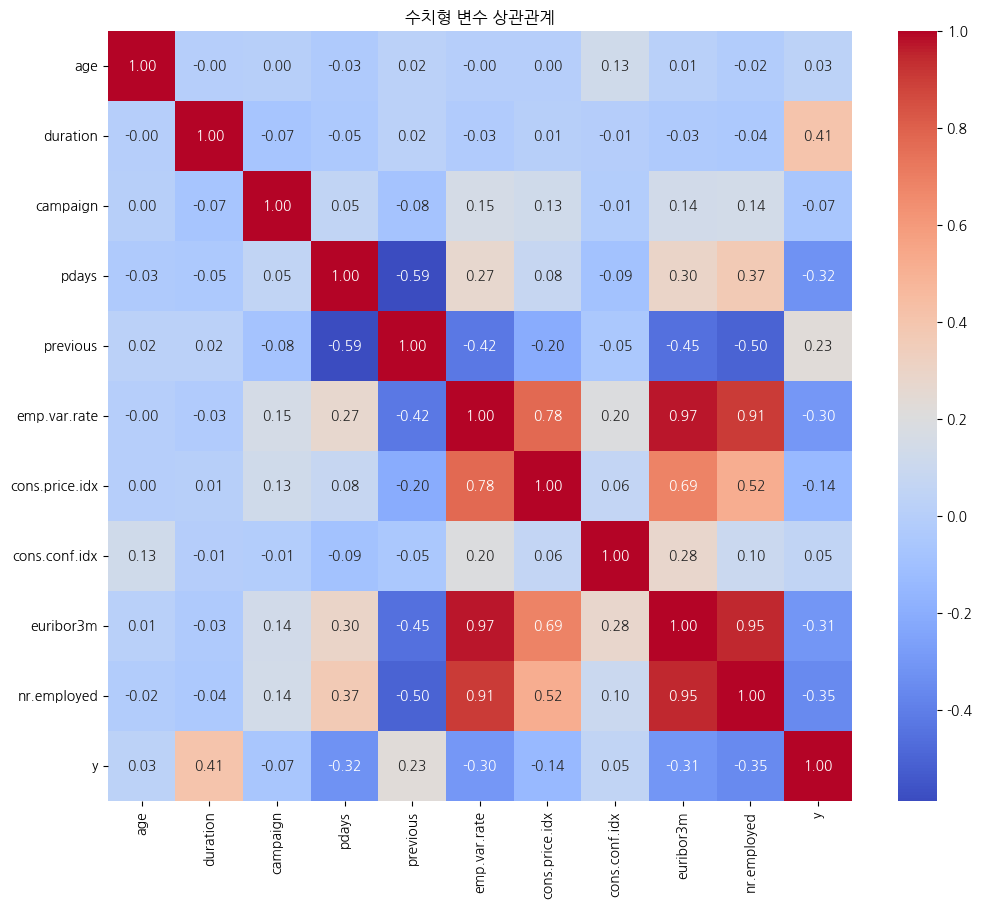

In [ ]:
num_cols = raw_train.select_dtypes(include=['int64', 'float64']).columns

corr = raw_train[num_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('수치형 변수 상관관계')
plt.show()

고용 변동률(emp.var.rate)와 소비자 물가지수(cons.price.idx) 사이에 양의 상관관계 확인  
유리보와 고용변동률의 상관관계 확인

##### - (추가 조사) 나이별 가입 여부

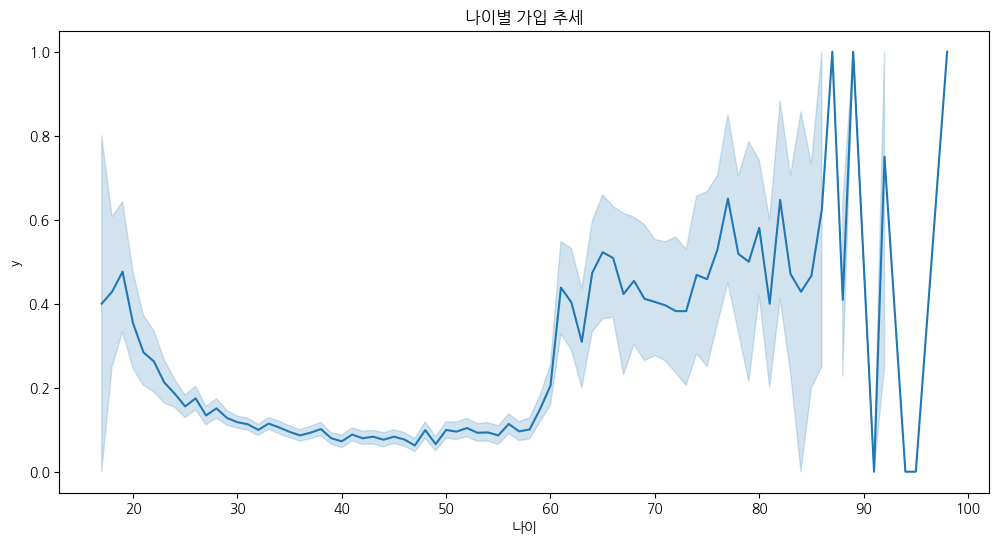

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(raw_train, x='age', y='y')
plt.title('나이별 가입 추세')
plt.xlabel('나이')
plt.show()


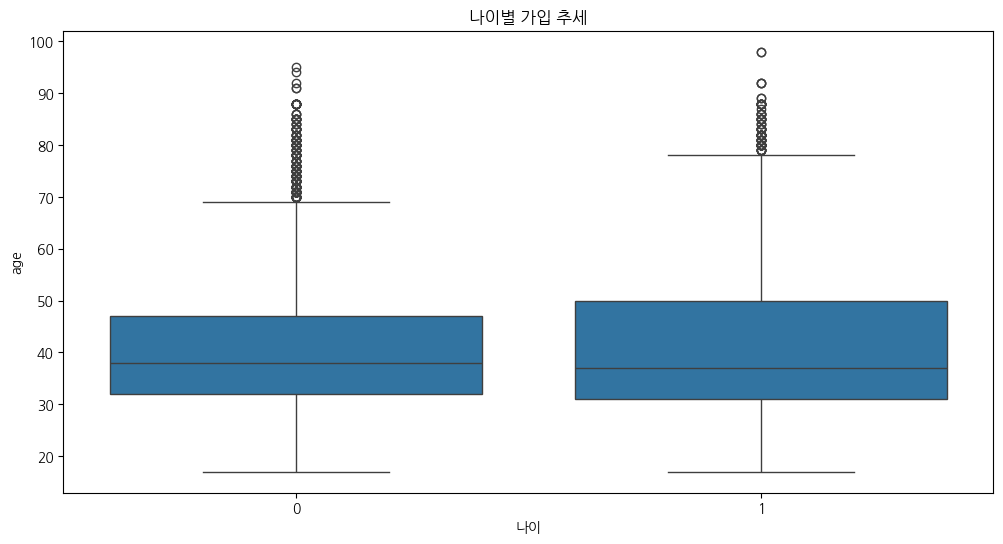

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(raw_train, x='y', y='age')
plt.title('나이별 가입 추세')
plt.xlabel('나이')
plt.show()

이것만 보면 상당히 극단적으로 고령에 쏠려 있지만 실제로는 3~50대 사이가 중추다.(이상치)

/tmp/ipython-input-1437992726.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = raw_train.groupby('age_group')['y'].count()


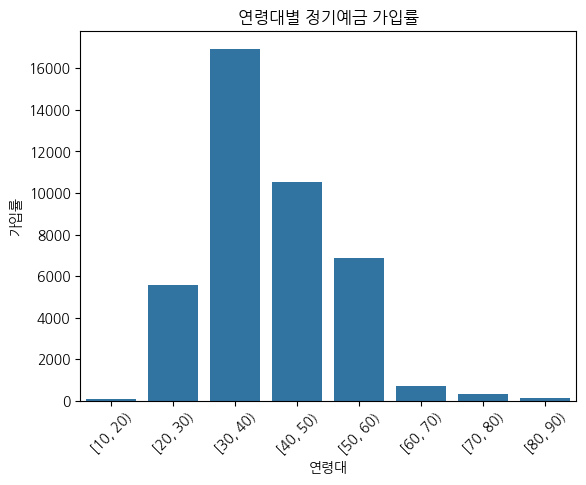

In [ ]:
raw_train['age_group'] = pd.cut(raw_train['age'], bins=range(10, 100, 10), right=False)

rate = raw_train.groupby('age_group')['y'].count()

sns.barplot(rate)
plt.title('연령대별 정기예금 가입률')
plt.xlabel('연령대')
plt.ylabel('가입률')
plt.xticks(rotation=45)
plt.show()

#### 범주형 데이터 가입 여부 확인

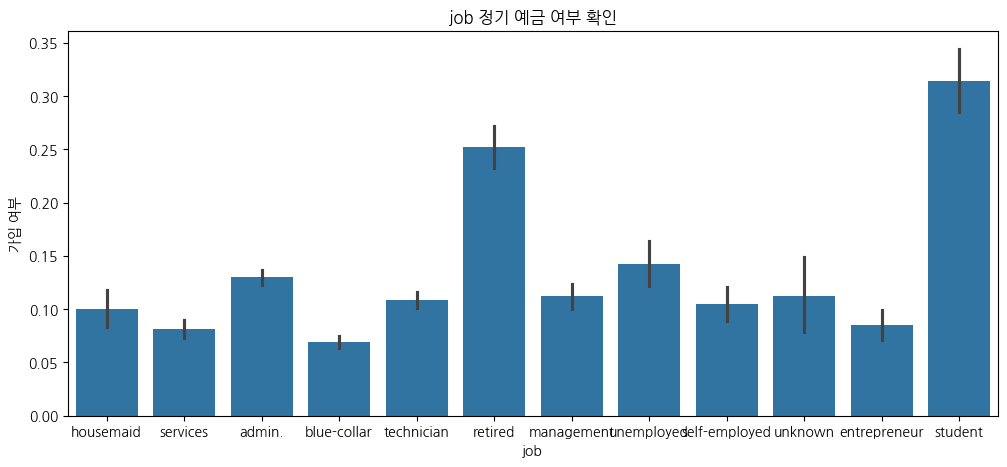

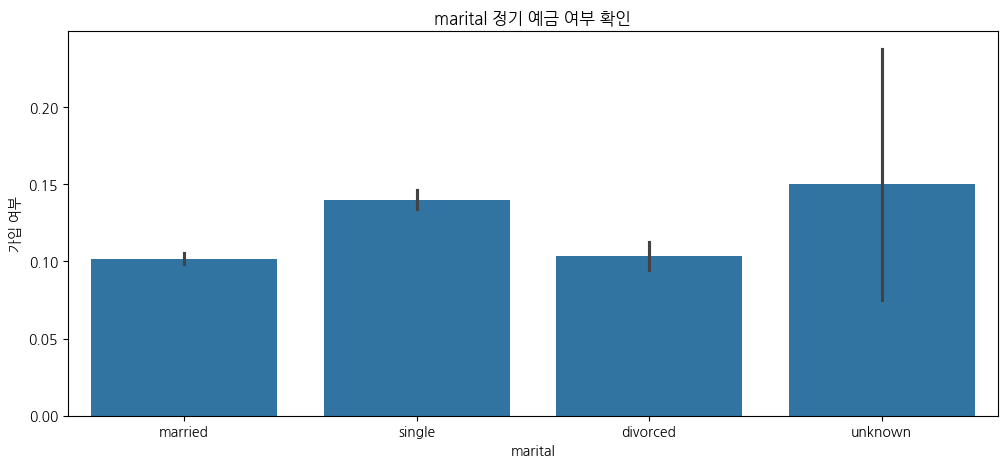

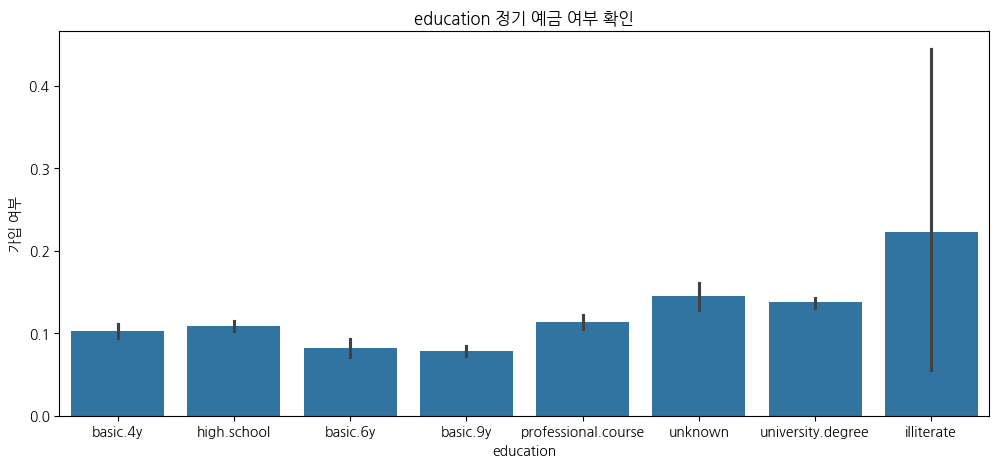

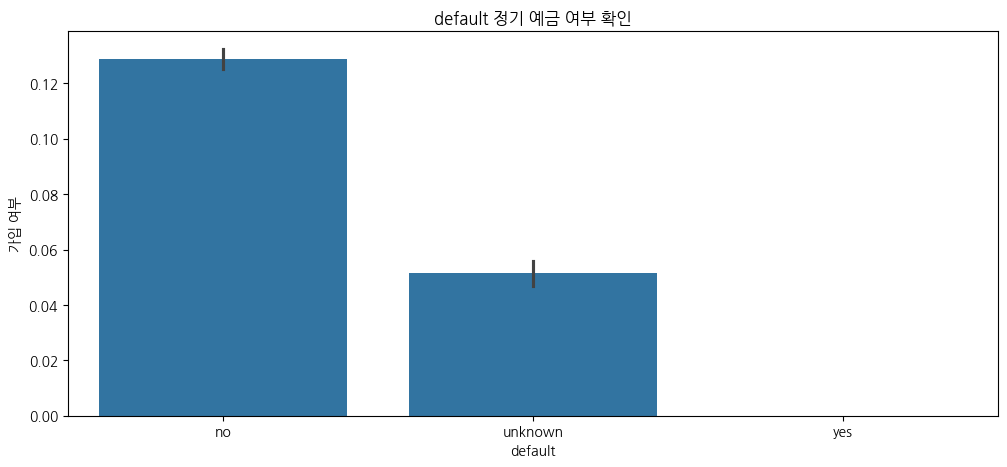

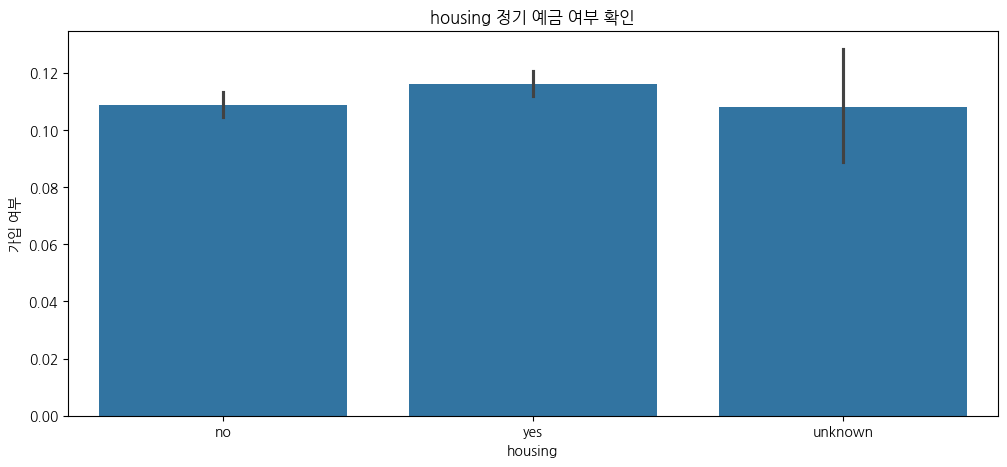

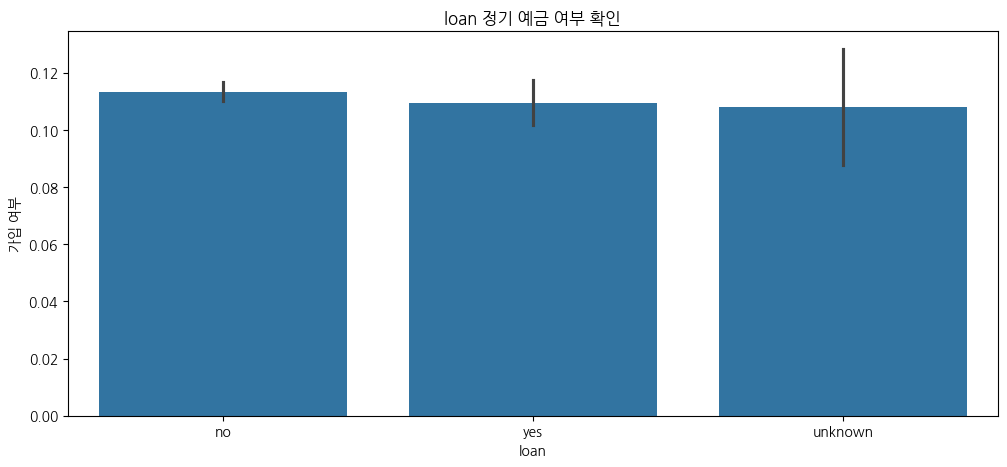

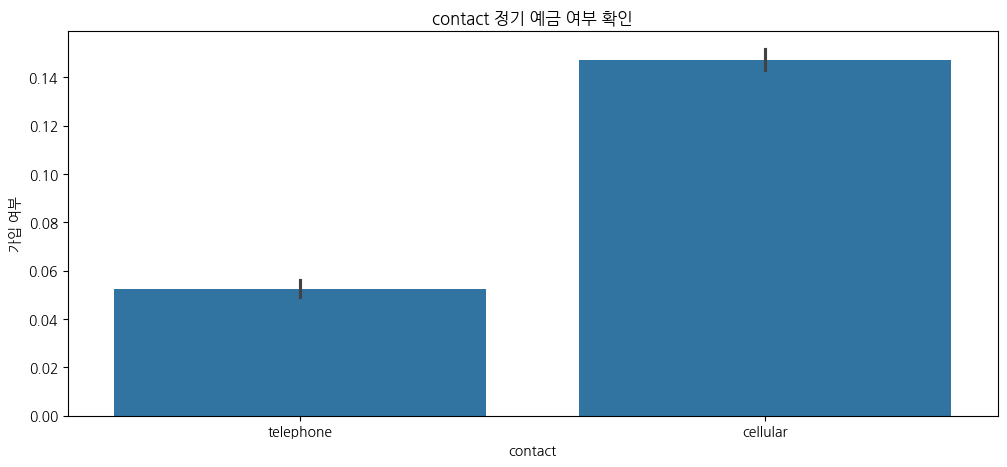

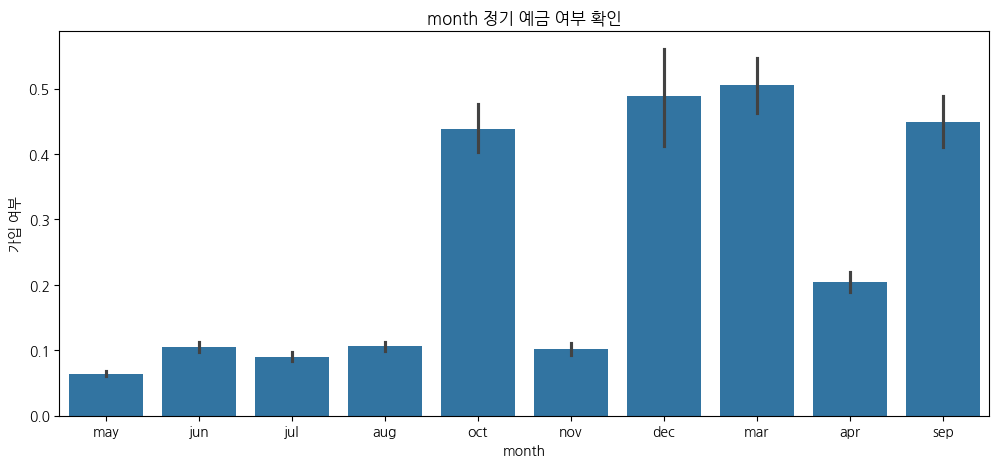

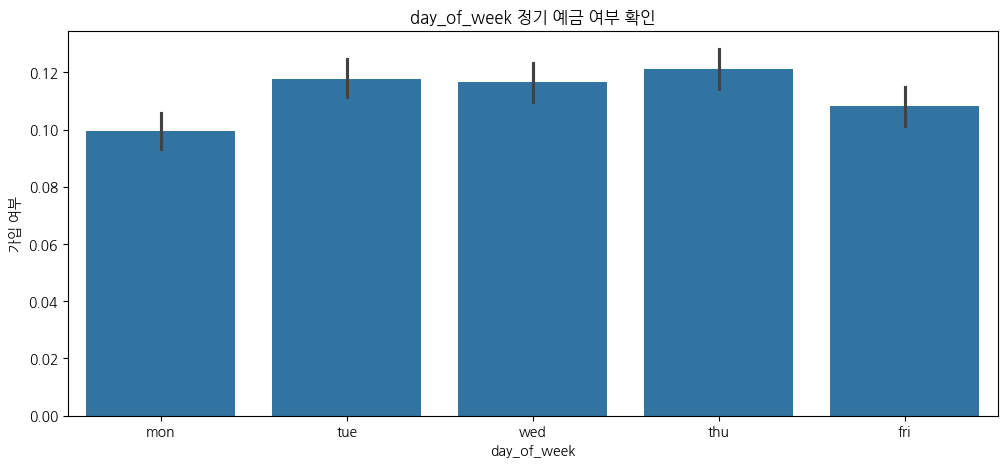

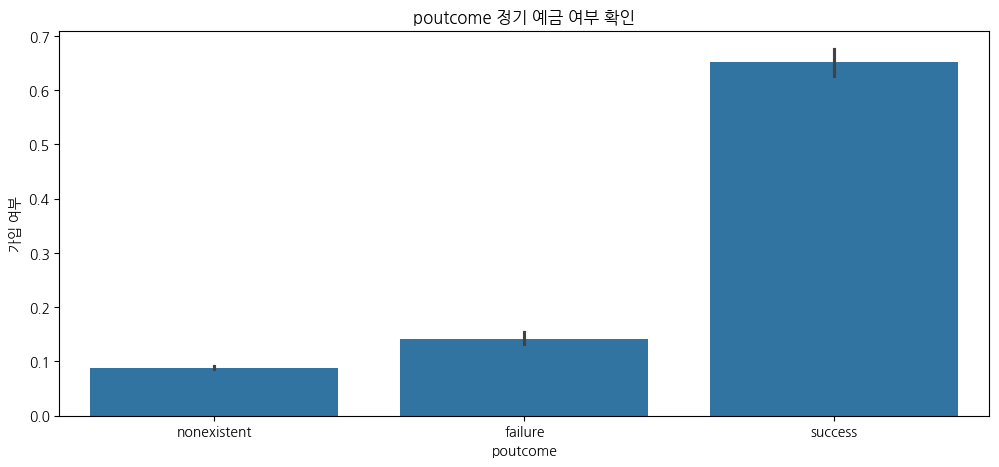

In [ ]:
# 하나하나 다 코드 짜면 시간이 많이 걸리므로 for 문 사용한 일괄 그래프화
cat_cols = raw_train.select_dtypes('object').columns

for col in cat_cols:
    plt.figure(figsize=(12, 5))
    sns.barplot(raw_train, x=col, y='y')
    plt.title(f'{col} 정기 예금 여부 확인')
    plt.xlabel(col)
    plt.ylabel('가입 여부')

    plt.show()



default(신용 불량 여부)는 예상대로 no일 때만 가입되어 있다.  
contact(연락 유형)은 휴대폰(cellular)이 월등히 많다.  
poutcome(이전 캠페인의 결과)가 성공인 사람의 비율이 훨씬 높다.

#####- (추가 조사) 직업별 가입 여부

In [ ]:
# 직업의 유니크 범주 개수 식별
np.unique_values(raw_train['job'])


array(['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
       'retired', 'self-employed', 'services', 'student', 'technician',
       'unemployed', 'unknown'], dtype=object)

이것들을 수익이 있는 직업과 없는 직업으로 나눈다.

In [ ]:
#isin 메서드로
raw_train['job_class'] = raw_train['job'].isin(['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'services', 'technician']).astype(int)

raw_train.groupby('job_class')['y'].count()

,y
job_class,
0,5360
1,35828


# 4. 데이터 전처리

제외할 변수 선정  
- `duration`: 전화 통화가 끝난 후에만 알 수 있는 값이기 때문에, 전화를 걸기 전까지는 얼마나 지속된 통화인지 알 수 없으므로 변수로 사용하기 부적합하다고 판단
- `emp.var.rate`, `euribor3m`, `cons.price.idx`, `nr.employed`: 고객의 특성이 아닌 해당 시점의 경제 상황을 반영하는 변수 삭제
- `day_of_week` 연락 요일 정보의 중요도가 높게 나오는 것은 이상하다. 이는 직원의 일정에 의존하는 변수이므로 고객의 패턴을 분석하는 데 부적합하다고 생각하여 추가 제거

변수 설명  

| 변수명 | 설명 |
|--------|--------|
| age |	나이 (숫자) |  
| job |	직업 (범주형) |  <- 데이터 분석 과정에서 만든 job_class 사용
| marital |	결혼 여부 (범주형) |  
| education	| 교육 수준 (범주형) |  
| default	| 신용 불량 여부 (범주형) |
| housing |	주택 대출 여부 (범주형) |  
| loan |	개인 대출 여부 (범주형) |  
| contact |	연락 유형 (범주형) |  
| month |	마지막 연락 월 (범주형) |  
| day_of_week |	마지막 연락 요일 (범주형) |  
| duration |	마지막 연락 지속 시간, 초 단위 (숫자) |  
| campaign |	캠페인 동안 연락 횟수 (숫자) |  
| pdays |	이전 캠페인 후 지난 일수 (숫자) |  
| previous |	이전 캠페인 동안 연락 횟수 (숫자) |  
| poutcome |	이전 캠페인의 결과 (범주형) |  
| emp.var.rate |	고용 변동률 (숫자) |  
| cons.price.idx |	소비자 물가지수 (숫자) |  
| cons.conf.idx |	소비자 신뢰지수 (숫자) |  
| euribor3m |	3개월 유리보 금리 (숫자) |  
| nr.employed |	고용자 수 (숫자) |  

In [ ]:
# 데이터 분리
x_data = raw_train.drop(['y', 'duration', 'job', 'age_group', 'emp.var.rate', 'euribor3m', 'cons.price.idx', 'nr.employed', 'day_of_week'], axis=1)
y_data = raw_train[['y']]


In [ ]:
# 학습 데이터 테스트 데이터 분리
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

In [ ]:
x_data['education']

,education
0,basic.4y
1,high.school
2,high.school
3,basic.6y
4,high.school
...,...
41183,professional.course
41184,professional.course
41185,university.degree
41186,professional.course


In [ ]:
# 여러 범주형 변수 열을 한 번에 인코딩할 수 있도록 OrdinalEncoder()를 사용한 클래스 생성
cat_cols = x_data.select_dtypes('object').columns


class Cat_Transformer:
    # 초기화로 OrdinalEncoder 가져오기.
    def __init__(self, cat_cols):
        self.cat_cols = cat_cols
        self.encoder = OrdinalEncoder()

    # 훈련 데이터용
    def fit_transform(self, df_data):
        df_data[self.cat_cols] = self.encoder.fit_transform(df_data[self.cat_cols])
        return df_data

    # 테스트 데이터용
    def transform(self, df_data):
        df_data[self.cat_cols] = self.encoder.transform(df_data[self.cat_cols])
        return df_data

In [ ]:
# 훈련 데이터와 테스트 데이터 인코딩
encoder = Cat_Transformer(cat_cols)

x_train = encoder.fit_transform(x_train)
x_test = encoder.transform(x_test)

In [ ]:
# 잘 인코딩되었는지 확인
x_train

,age,marital,education,default,housing,loan,contact,month,campaign,pdays,previous,poutcome,cons.conf.idx,job_class
25611,49,1.0,2.0,1.0,0.0,0.0,0.0,7.0,4,999,0,1.0,-42.0,1
26010,37,1.0,6.0,0.0,0.0,0.0,1.0,7.0,2,999,1,0.0,-42.0,1
40194,78,1.0,0.0,0.0,0.0,0.0,0.0,3.0,1,999,0,1.0,-40.3,0
297,36,1.0,6.0,0.0,2.0,0.0,1.0,6.0,2,999,0,1.0,-36.4,1
36344,59,0.0,6.0,0.0,0.0,0.0,0.0,4.0,2,999,0,1.0,-40.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40205,28,2.0,3.0,0.0,2.0,0.0,0.0,3.0,1,999,0,1.0,-40.3,1
27316,52,1.0,5.0,0.0,2.0,0.0,0.0,7.0,1,999,1,0.0,-42.0,1
14392,54,1.0,2.0,0.0,0.0,2.0,0.0,3.0,4,999,0,1.0,-42.7,1
7494,29,1.0,6.0,0.0,0.0,0.0,1.0,6.0,1,999,0,1.0,-36.4,1


# 5. 모델링

## 5.1. 그리드서치

In [ ]:
# 사용할 모델 후보군
# CatBoost는 verbose=0을 안 하면 터미널에 로그가 너무 많이 찍히므로 추가
models = {'XGB': XGBClassifier(random_state=42), 'CAT': CatBoostClassifier(verbose=0, random_state=42)}

# 파라미터 후보군
params = {
          'XGB': {'max_depth': [i for i in range(2, 6, 2)],
                  'learning_rate': [0.1, 0.3, 0.5, 1],
                  'n_estimators': [i for i in range(30, 300, 30)]
                  },
          'CAT': {'depth': [i for i in range(2, 6, 2)],
                  'learning_rate': [0.1, 0.3, 0.5, 1],
                  'iterations': [i for i in range(30, 300, 30)]
                  }
          }

# 그리드 서치

for i in models:
    grid = GridSearchCV(models[i], params[i], cv=5)
    grid.fit(x_train, y_train)
    print(f'{i}의 파라미터:', grid.best_params_)
    print(f'{i}의 모델', grid.best_estimator_)
    print(f'{i}의 점수', grid.best_score_)



XGB의 파라미터: {'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 30}
XGB의 모델 XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=30,
              n_jobs=None, num_parallel_tree=None, ...)
XGB의 점수 0.8996965098634295
CAT의 파라미터: {'depth': 4, 'iterations': 60, 'learning_rate': 0.1}
CAT의 모델 <catboost.core.CatBoostClassifier object at 0x7e0e9d7b4c80>
CAT의 점수 

결과: 아주 미세한 차이로 CatBoost의 점수가 더 높다.

## 5.2. XGBoost 모델을 사용한 예측(연습용)

In [ ]:
# accuracy_score, classification_report로 점수를 평가해 보기
xgb = XGBClassifier(learning_rate=0.3, max_depth=2, n_estimators=30, random_state=42)
xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=30,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# 훈련 데이터 예측
y_tpred = xgb.predict(x_train)

print(accuracy_score(y_train, y_tpred))
print('=' * 100)
print(classification_report(y_train, y_tpred))

0.89948406676783
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     29238
           1       0.69      0.20      0.31      3712

    accuracy                           0.90     32950
   macro avg       0.80      0.59      0.63     32950
weighted avg       0.88      0.90      0.87     32950



In [ ]:
# 예측
y_pred = xgb.predict(x_test)

print(accuracy_score(y_test, y_pred))
print('=' * 100)
print(classification_report(y_test, y_pred))

0.899368778829813
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7310
           1       0.70      0.19      0.29       928

    accuracy                           0.90      8238
   macro avg       0.80      0.59      0.62      8238
weighted avg       0.88      0.90      0.87      8238



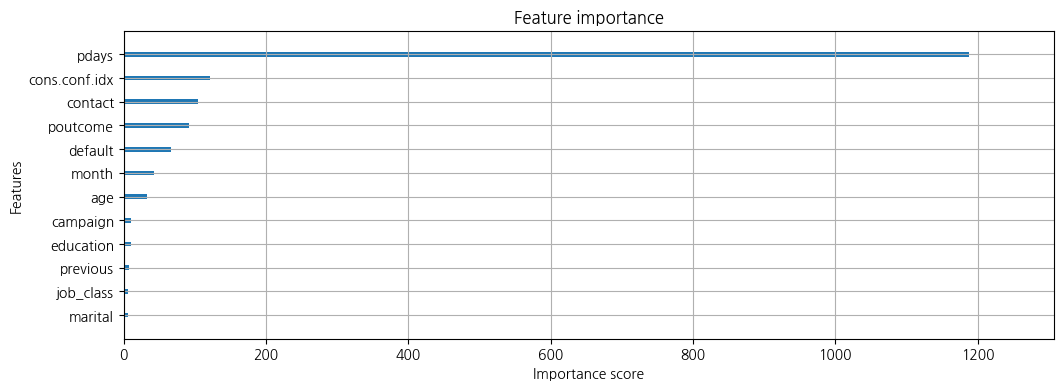

In [ ]:
_, ax = plt.subplots(figsize=(12, 4))
plot_importance(xgb,
                ax=ax,
                importance_type='gain',
                show_values=False)
plt.show()

### 결과
- 과적합은 아니지만 클래스 불균형의 증상이 보인다.
- nr.employed	고용자 수 (숫자)가 비정상적으로 높은 중요도를 보인다.

## 5.3. CatBoost 모델을 사용한 예측(연습용)

In [ ]:
# accuracy_score, classification_report로 점수를 평가해 보기
cat = CatBoostClassifier(depth=4, iterations=60, learning_rate=0.1, verbose=0, random_state=42)
cat.fit(x_train, y_train)

In [ ]:
# 훈련 데이터 예측
y_ctpred = cat.predict(x_train)

print(accuracy_score(y_train, y_ctpred))
print('=' * 100)
print(classification_report(y_train, y_ctpred))

0.8997875569044006
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     29238
           1       0.69      0.20      0.31      3712

    accuracy                           0.90     32950
   macro avg       0.80      0.59      0.63     32950
weighted avg       0.88      0.90      0.87     32950



In [ ]:
# 예측
y_cpred = cat.predict(x_test)

print(accuracy_score(y_test, y_cpred))
print('=' * 100)
print(classification_report(y_test, y_cpred))

0.9002184996358339
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7310
           1       0.72      0.19      0.30       928

    accuracy                           0.90      8238
   macro avg       0.81      0.59      0.62      8238
weighted avg       0.88      0.90      0.87      8238



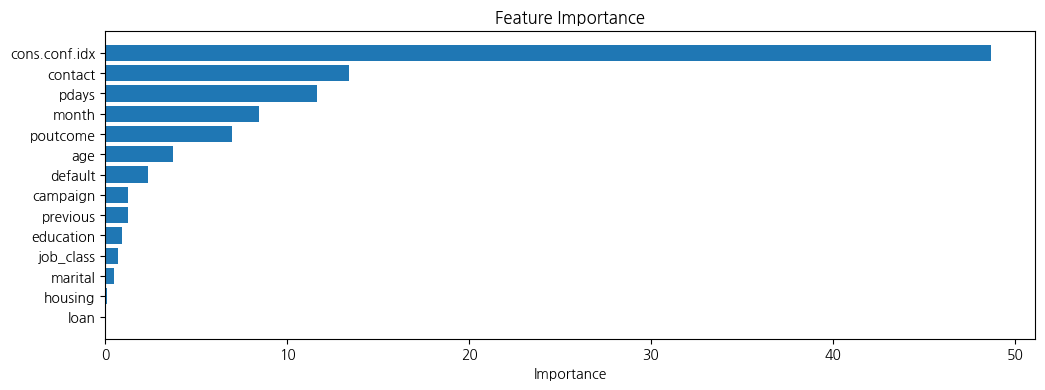

In [ ]:
# catboost는 plot_importance나 plot_tree 같은 게 없으므로 직접 중요도 계산
importance = cat.get_feature_importance()
feat_imp = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(12,4))
# barch로 가로 막대 그래프 그리기
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
# Get Current Axes를 사용해서 중요도 높은 것이 위로 오도록 반전
plt.gca().invert_yaxis()
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.show()

### 결과
- XGBoost보다는 미세하게 좋은 결과를 보이지만 여전히 클래스 불균등 문제 포착

## 5.3. Optuna를 사용한 클래스 불균형 문제 해결

- 양성 클래스(1)를 잘 맞추지 못하는 클래스 불균형 문제 개선 방법 추구
- 클래스 불균등 문제를 방지하기 위해서는 XGBoost의 경우 `scale_pos_weight`, CatBoost의 경우 `class_weights` 파라미터로 소수 클래스에 가중치 부여 필요.
- 좀 더 좋은 성능을 보여 준 CatBoost를 사용

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 11.8 MB/s eta 0:00:00


In [ ]:
!pip install -U -qqq hiplot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.2/863.2 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.2/494.2 kB 6.4 MB/s eta 0:00:00


In [ ]:
import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_optimization_history, plot_param_importances

In [ ]:
# 이번에는 검증 데이터 사용
x_ctrain, x_ctemp, y_ctrain, y_ctemp = train_test_split(x_data, y_data, test_size=0.3, random_state=42, stratify=y_data)
x_cval, x_ctest, y_cval, y_ctest = train_test_split(x_ctemp, y_ctemp, test_size=0.5, random_state=42, stratify=y_ctemp)

In [ ]:
# OrdinalEncoing 적용
x_ctrain = encoder.fit_transform(x_ctrain)
x_cval = encoder.transform(x_cval)
x_test = encoder.transform(x_ctest)

In [ ]:
# CatBoost를 위한 목적 함수 정의
def objective(trial):
    # 클래스별 데이터 세기
    w0 = len(y_ctrain[y_ctrain == 0])
    w1 = len(y_ctrain[y_ctrain == 1])
    params = {
        # optuna의 suggest_in와 suggest_float로 범위 지정: name, low, high, step
        'depth': trial.suggest_int('depth', 4, 10), # 트리 깊이
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3), # 학습률 찾기
        'iterations': trial.suggest_int('iterations', 200, 1000), # 트리 개수
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10), # l2 규제
        'class_weights': [1.0, w0 / w1],  # 0번 클래스 가중치=1.0, 1번 클래스 가중치=w0/w1로 설정
        'random_state': 42,
        'verbose': False,
        'eval_metric': 'F1' # 평가 로그를 F1로 설정
    }
    model = CatBoostClassifier(**params)

    model.fit(x_ctrain, y_ctrain, eval_set=[(x_cval, y_cval)],) # eval_set로 검증 데이터를 넣어 학습 중 검증
    y_pred = model.predict(x_cval)
    return f1_score(y_cval, y_pred)

# Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction='maximize') # f1을 maximize하는 방향으로 설정
# 시도 횟수 n_trials = 50번
study.optimize(objective, n_trials=100)

print(f"CatBoost: 최적의 값 = {study.best_value}\n최적의 파라미터 = {study.best_params}")
print("Best trial:\n\n")
trial = study.best_trial

print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"{key}: {value}")

[I 2025-10-22 23:17:43,535] A new study created in memory with name: no-name-1e702a0f-77f1-41f9-b2f0-e271f4cd8df6
[I 2025-10-22 23:18:06,095] Trial 0 finished with value: 0.396484375 and parameters: {'depth': 4, 'learning_rate': 0.29220478325951654, 'iterations': 993, 'l2_leaf_reg': 5.33297473589397}. Best is trial 0 with value: 0.396484375.
[I 2025-10-22 23:18:19,401] Trial 1 finished with value: 0.3731193580742227 and parameters: {'depth': 5, 'learning_rate': 0.2389340665479844, 'iterations': 395, 'l2_leaf_reg': 3.94289657944715}. Best is trial 0 with value: 0.396484375.
[I 2025-10-22 23:18:36,983] Trial 2 finished with value: 0.3604531410916581 and parameters: {'depth': 9, 'learning_rate': 0.028898838272499394, 'iterations': 817, 'l2_leaf_reg': 5.444579718992946}. Best is trial 0 with value: 0.396484375.
[I 2025-10-22 23:18:51,647] Trial 3 finished with value: 0.40234375 and parameters: {'depth': 8, 'learning_rate': 0.13342952306448275, 'iterations': 955, 'l2_leaf_reg': 6.4318115302

CatBoost: 최적의 값 = 0.4222222222222222
최적의 파라미터 = {'depth': 8, 'learning_rate': 0.2711916511838262, 'iterations': 924, 'l2_leaf_reg': 4.389655103799035}
Best trial:


Value:  0.4222222222222222
Params: 
depth: 8
learning_rate: 0.2711916511838262
iterations: 924
l2_leaf_reg: 4.389655103799035


In [ ]:
# 훈련 과정 시각화
plot_optimization_history(study)

In [ ]:
# accuracy_score, classification_report로 점수를 평가해 보기
w0 = len(y_ctrain[y_ctrain == 0])
w1 = len(y_ctrain[y_ctrain == 1])
re_cat = CatBoostClassifier(depth=8,
                            learning_rate=0.2711916511838262,
                            iterations=924,
                            l2_leaf_reg=4.389655103799035,
                            class_weights=[1.0, w0 / w1],  # 자동으로 클래스 불균형 조정
                            random_state=42,
                            verbose=0,
                            eval_metric='F1'
                            )
re_cat.fit(x_ctrain, y_ctrain)

In [ ]:
# 훈련 데이터 예측
y_re_pred = re_cat.predict(x_ctrain)

print(accuracy_score(y_ctrain, y_re_pred))
print('=' * 100)
print(classification_report(y_ctrain, y_re_pred))

0.9657313308591446
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     25583
           1       0.99      0.71      0.82      3248

    accuracy                           0.97     28831
   macro avg       0.97      0.85      0.90     28831
weighted avg       0.97      0.97      0.96     28831



In [ ]:
# 예측
y_re_vpred = re_cat.predict(x_cval)

print(accuracy_score(y_cval, y_re_vpred))
print('=' * 100)
print(classification_report(y_cval, y_re_vpred))

0.8949498219488508
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      5482
           1       0.56      0.32      0.41       696

    accuracy                           0.89      6178
   macro avg       0.74      0.64      0.68      6178
weighted avg       0.88      0.89      0.88      6178



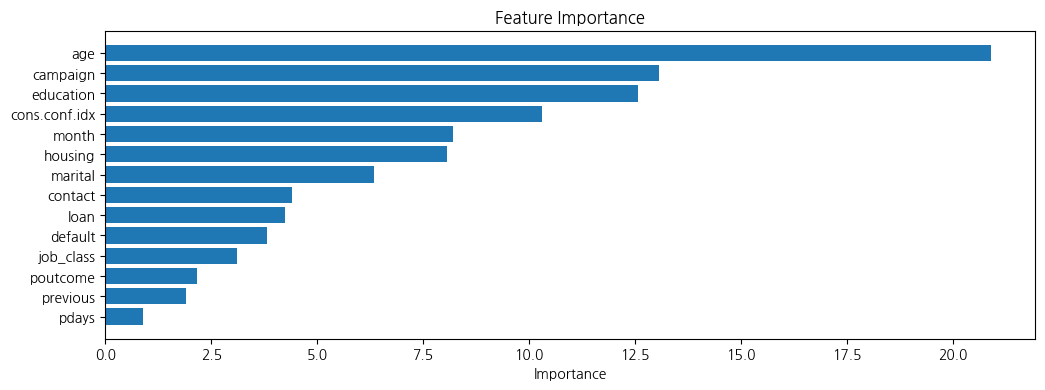

In [ ]:
# catboost는 plot_importance나 plot_tree 같은 게 없으므로 직접 중요도 계산
importance = re_cat.get_feature_importance()
feat_imp = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(12,4))
# barch로 가로 막대 그래프 그리기
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
# Get Current Axes를 사용해서 중요도 높은 것이 위로 오도록 반전
plt.gca().invert_yaxis()
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.show()

### 결과
- 조금은 클래스 불균형 문제가 개선되었지만, 여전히 낮은 f1 점수를 보인다.

## 5.4. 추가 개선

- SMOTE로 소수 클래스 오버 샘플링  
- 양성 데이터(1)가 너무 적으므로 threshold 조정


In [ ]:
!pip install imblearn

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.preprocessing import StandardScaler

In [ ]:
# SMOTE를 사용하여 오버 샘플링
smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(x_ctrain, y_ctrain)

In [ ]:
# CatBoost를 위한 목적 함수 정의
def objective(trial):
    params = {
        # optuna의 suggest_in와 suggest_float로 범위 지정: name, low, high, step
        'depth': trial.suggest_int('depth', 4, 10), # 트리 깊이
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3), # 학습률 찾기
        'iterations': trial.suggest_int('iterations', 200, 1000), # 트리 개수
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10), # l2 규제
        'random_state': 42,
        'verbose': False,
        'eval_metric': 'F1', # 평가 로그를 F1로 설정
    }
    model = CatBoostClassifier(**params)

    model.fit(X_res, y_res, eval_set=[(x_cval, y_cval)],) # eval_set로 검증 데이터를 넣어 학습 중 검증
    y_pred = model.predict(x_cval)
    return f1_score(y_cval, y_pred)

# Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction='maximize') # f1을 maximize하는 방향으로 설정
# 시도 횟수 n_trials = 50번
study.optimize(objective, n_trials=50)

print(f"CatBoost: 최적의 값 = {study.best_value}\n최적의 파라미터 = {study.best_params}")
print("Best trial:\n\n")
trial = study.best_trial

print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"{key}: {value}")

[I 2025-10-23 00:07:51,015] A new study created in memory with name: no-name-71cab041-c835-4fdd-a7ec-a0a4d6464e58
[I 2025-10-23 00:08:11,441] Trial 0 finished with value: 0.47690014903129657 and parameters: {'depth': 9, 'learning_rate': 0.2734600193639865, 'iterations': 410, 'l2_leaf_reg': 3.604520922362237}. Best is trial 0 with value: 0.47690014903129657.
[I 2025-10-23 00:08:28,837] Trial 1 finished with value: 0.46437552388935455 and parameters: {'depth': 6, 'learning_rate': 0.2919783489945826, 'iterations': 836, 'l2_leaf_reg': 5.283593368488609}. Best is trial 0 with value: 0.47690014903129657.
[I 2025-10-23 00:08:38,359] Trial 2 finished with value: 0.48246844319775595 and parameters: {'depth': 5, 'learning_rate': 0.06881418707262979, 'iterations': 415, 'l2_leaf_reg': 2.5953908394978193}. Best is trial 2 with value: 0.48246844319775595.
[I 2025-10-23 00:08:59,786] Trial 3 finished with value: 0.4728624535315985 and parameters: {'depth': 6, 'learning_rate': 0.052429727533855316, 'i

CatBoost: 최적의 값 = 0.4897381457891012
최적의 파라미터 = {'depth': 10, 'learning_rate': 0.09799213632485249, 'iterations': 649, 'l2_leaf_reg': 1.2357370573162814}
Best trial:


Value:  0.4897381457891012
Params: 
depth: 10
learning_rate: 0.09799213632485249
iterations: 649
l2_leaf_reg: 1.2357370573162814


In [ ]:
# 훈련 과정 시각화
plot_optimization_history(study)

In [ ]:
# accuracy_score, classification_report로 점수를 평가해 보기
fin_cat = CatBoostClassifier(depth=10,
                            learning_rate=0.09799213632485249,
                            iterations=649,
                            l2_leaf_reg=1.2357370573162814,
                            random_state=42,
                            verbose=0,
                            eval_metric='F1',
                            )
fin_cat.fit(X_res, y_res)

In [ ]:
# 훈련 데이터 예측
y_fin_pred = fin_cat.predict(X_res)

print(accuracy_score(y_res, y_fin_pred))
print('=' * 100)
print(classification_report(y_res, y_fin_pred))

0.9709361735576167
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     25444
           1       0.99      0.95      0.97     25444

    accuracy                           0.97     50888
   macro avg       0.97      0.97      0.97     50888
weighted avg       0.97      0.97      0.97     50888



In [ ]:
# 검증 데이터에서 확률 예측
fin_cat.predict_proba(x_cval)

array([[0.97300207, 0.02699793],
       [0.72725979, 0.27274021],
       [0.98309503, 0.01690497],
       ...,
       [0.96089084, 0.03910916],
       [0.59688075, 0.40311925],
       [0.99684722, 0.00315278]])

In [ ]:
# 확률 예측에서 슬라이싱으로 1에 속할 확률만 가져오기
y_vprob = fin_cat.predict_proba(x_cval)[:, 1]

# 여러 threshold로 F1/Recall 테스트
best_t, best_f1 = 0, 0
for t in np.arange(0.1, 0.9, 0.02):
    y_vpred_t = (y_vprob > t).astype(int)
    f1 = f1_score(y_cval, y_vpred_t)
    rec = recall_score(y_cval, y_vpred_t)
    prec = precision_score(y_cval, y_vpred_t)
    print(f"Threshold={t:.3f} | F1={f1:.3f} | Recall={rec:.3f} | Precision={prec:.3f}")

    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print(f"최고 Threshold = {best_t:.3f} (F1={best_f1:.3f})")

# 최적 threshold로 최종 평가
y_pred_best = (y_vprob > best_t).astype(int)
print(classification_report(y_cval, y_pred_best))

Threshold=0.100 | F1=0.344 | Recall=0.616 | Precision=0.239
Threshold=0.120 | F1=0.359 | Recall=0.586 | Precision=0.259
Threshold=0.140 | F1=0.371 | Recall=0.563 | Precision=0.277
Threshold=0.160 | F1=0.379 | Recall=0.540 | Precision=0.292
Threshold=0.180 | F1=0.391 | Recall=0.522 | Precision=0.312
Threshold=0.200 | F1=0.396 | Recall=0.504 | Precision=0.326
Threshold=0.220 | F1=0.401 | Recall=0.489 | Precision=0.340
Threshold=0.240 | F1=0.409 | Recall=0.480 | Precision=0.356
Threshold=0.260 | F1=0.417 | Recall=0.473 | Precision=0.373
Threshold=0.280 | F1=0.424 | Recall=0.463 | Precision=0.392
Threshold=0.300 | F1=0.425 | Recall=0.451 | Precision=0.403
Threshold=0.320 | F1=0.424 | Recall=0.438 | Precision=0.410
Threshold=0.340 | F1=0.421 | Recall=0.421 | Precision=0.421
Threshold=0.360 | F1=0.422 | Recall=0.411 | Precision=0.434
Threshold=0.380 | F1=0.413 | Recall=0.391 | Precision=0.438
Threshold=0.400 | F1=0.414 | Recall=0.381 | Precision=0.454
Threshold=0.420 | F1=0.415 | Recall=0.37

In [ ]:
# precision_recall_curve로 최적의 threshold 값 재추적
prec, rec, thresh = precision_recall_curve(y_cval, y_vprob)

f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
best_idx = np.argmax(f1)
best_t = thresh[best_idx]
print(f"최고 Threshold: {best_t:.3f}, F1={f1[best_idx]:.3f}")

최고 Threshold: 0.327, F1=0.427


In [ ]:
# 최적 threshold로 다시 최종 평가
y_pred_best = (y_vprob > best_t).astype(int)
print(classification_report(y_cval, y_pred_best))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93      5482
           1       0.42      0.43      0.43       696

    accuracy                           0.87      6178
   macro avg       0.67      0.68      0.68      6178
weighted avg       0.87      0.87      0.87      6178



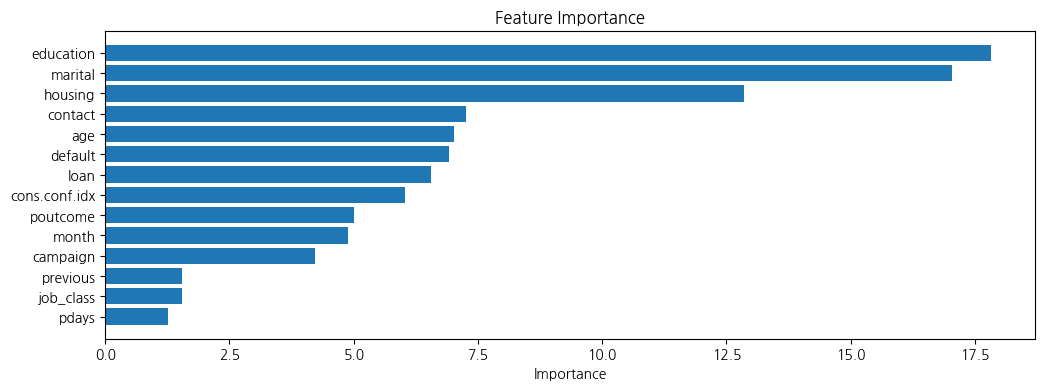

In [ ]:
# catboost는 plot_importance나 plot_tree 같은 게 없으므로 직접 중요도 계산
importance = fin_cat.get_feature_importance()
feat_imp = pd.DataFrame({
    'Feature': X_res.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(12,4))
# barch로 가로 막대 그래프 그리기
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
# Get Current Axes를 사용해서 중요도 높은 것이 위로 오도록 반전
plt.gca().invert_yaxis()
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.show()

In [ ]:
# 확률 예측에서 슬라이싱으로 1에 속할 확률만 가져오기
y_tprob = fin_cat.predict_proba(x_ctest)[:, 1]

# 최적 threshold로 최종 평가
y_tpred_best = (y_tprob > best_t).astype(int)
print(classification_report(y_ctest, y_tpred_best))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      5483
           1       0.42      0.42      0.42       696

    accuracy                           0.87      6179
   macro avg       0.67      0.67      0.67      6179
weighted avg       0.87      0.87      0.87      6179



## 6. 결론

- 과거 캠페인 성공 경험(poutcome)이 가입 예측에 큰 영향
- 연락 채널(contact)은 성과 차이를 크게 만듦
- 대출 여부(housing)도 영향
- 직업군(job_class)와 교육 수준(education) 또한 적지 않은 영향
- 기존 캠페인 성공 고객을 리타겟팅
- 신규 고객 유입 전략 필요